# 장고를 이용하여 인스타 크롤링 하기

## admin파일에 인스타 게시판 등록

In [ ]:
# insta/admin.py 파일에 다음을 입력하여 관리자 페이지에 인스타 크롤링 DB를 등록할 수 있게 만든다.
from django.contrib import admin
from .models import *
# Register your models here.
admin.site.register(Insta)

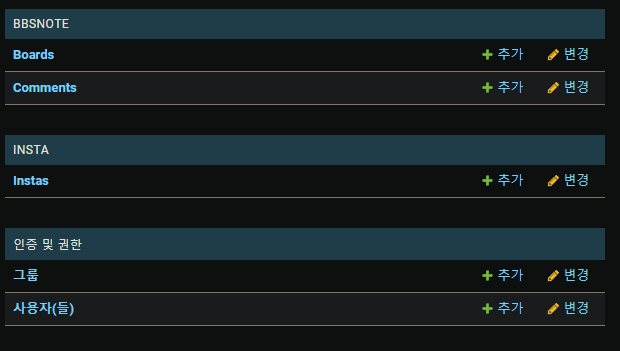

## 워드 클라우드 출력

* 워드클라우드 출력을 위해 settings.py에 STATIC_DIR 항목을 생성하여 BASE_DIR / 'static'를 추가한다.

In [ ]:
# settings.py파일에 다음을 추가
STATIC_DIR = BASE_DIR / 'static'

* 이후 url설정을 해준다.

In [ ]:
# insta/urls.py에 URL패턴 추가
urlpatterns = [
    path('', views.index, name = 'index'),
    # 워드클라우드를 실행시킬 URL패턴
    path('wordcloud/', views.wordcloud, name='wordcloud'),
]

* views.py파일에 wordcloud 뷰 함수를 추가해준다.

In [ ]:
# 워드 클라우드 함수
def wordcloud(request):
    # SELECT tags FROM inata.Insta
    tags_all = Insta.objects.values('tags')
    tags_all_df = pd.DataFrame(tags_all)
    
    # 해시태그 통합 저장
    tags_total = []
    for tags in tags_all_df['tags']:
        # 저장된 태그에서 "', '"를 기준으로 분할해준다
        tags_list = tags[2:-2].split("', '")
        for tag in tags_list:
            tags_total.append(tag)
            
    makeWordCloud(tags_total)
    return render(request, 'wordcloud.html')

* parser.py 파일에 워드클라우드 실행하기 위한 옵션이 들어갈 함수 역시 추가해준다.

In [ ]:
import platform
from config.settings import STATIC_DIR
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# parser.py파일에 다음의 함수 추가
def makeWordCloud(tags_total):
    # 워드 클라우드에 필요한 글꼴 지정
    # 윈도우의 경우
    if platform.system() == 'Windows':
        font_path = "c:/Windows/Fonts/malgun.ttf"
    # Mac 의 경우
    elif platform.system() == "Darwin":
        font_path = "/Users/$USER/Library/Fonts/AppleGothic.ttf"
        
    pic_info = STATIC_DIR / 'images/wordcloud1.png'
    
    STOPWORDS = ['', '#일상', '#맞팔', '#먹팔맞팔', '#데일리룩', 'ootd', '#fff', '#먹스타', '#먹스타맞팔', \
            '#소통', '#제주포토존', '#먹방', '#먹팔', '#좋아요', '#제주펜션', '#데일리', '#제주숙소', \
            '#팔로우', '#좋반', '#좋아요반사', 'daily', '#좋테']
    tag_total_selected = []
    for tag in tags_total:
        if tag not in STOPWORDS:
            tag_total_selected.append(tag)
            
    tag_counts_selected = Counter(tag_total_selected)
    tag_counts_selected.most_common(50)
    
    wordcloud=WordCloud(font_path= font_path,	# 사용할 글꼴 경로 
                    background_color="white",	# 배경색
                    max_words=50,		# 최대 몇 개의 단어를 나타낼 것인지 설정
                    relative_scaling= 0.3, 	# 워드 클라우드 내 글자들의 상대적인 크기(0~1)
                    width = 800,		# 워드클라우드 가로
                    height = 400		# 워드클라우드 세로
                ).generate_from_frequencies(tag_counts_selected)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    # 원하는 경로에 워드 클라우드 이미지 파일 저장
    plt.savefig(pic_info)

* views.py파일에서 선언했던 워드클라우드 html파일을 기존 bbsnote를 만들때 사용했던 templates폴더에 wordcloud.html을 생성해준다.

In [ ]:
# templates폴더 안에 wordcloud.html을 생성
{% load static %}
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta http-equiv="X-UA-Compatible" content="IE=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Document</title>
</head>
<body>
    <img src="{% static 'images/wordcloud1.png' %}"
</body>
</html>

* html파일의 body부분에 명시한 images안에 워드클라우드 결과물을 저장해야 하므로, static폴더안에 css와 동등한 위치로 images폴더를 생성해준다.

* 이후 터미널에서 runsercer를 실행 후, 링크창에 127.0.0.1:8000/insta/wordcloud를 입력하면 다음과 같이 워드클라우드가 나타난다.

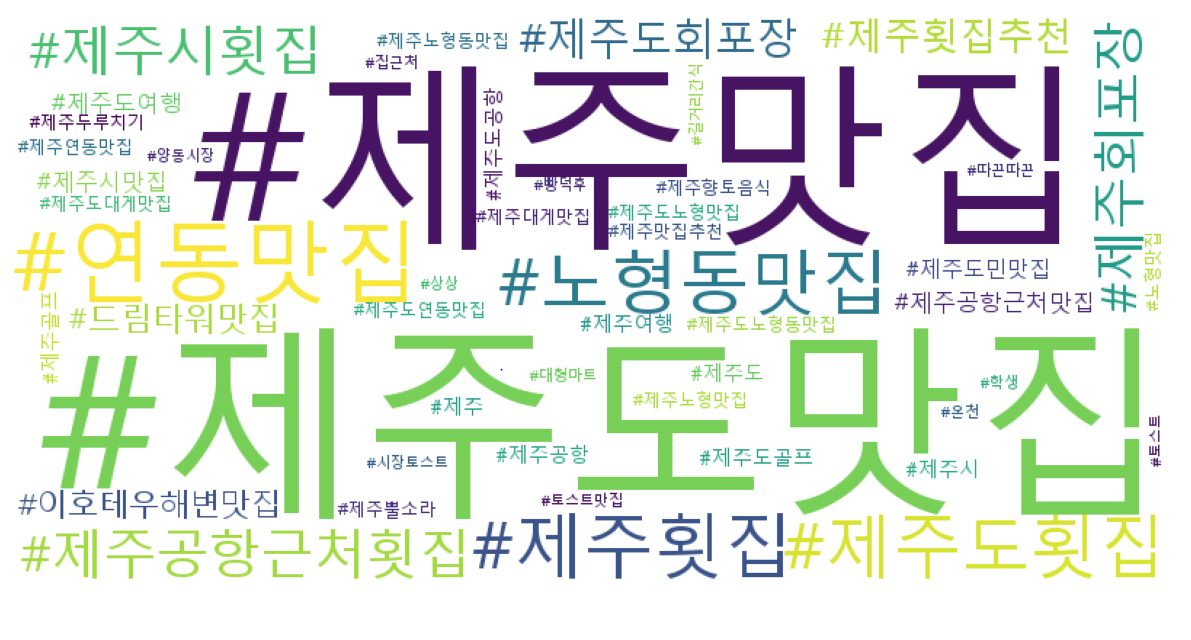

* 또한 vscode에서 images폴더안에도 wordcloud결과가 png파일의 형태로 젖아됨을 볼 수 있다.

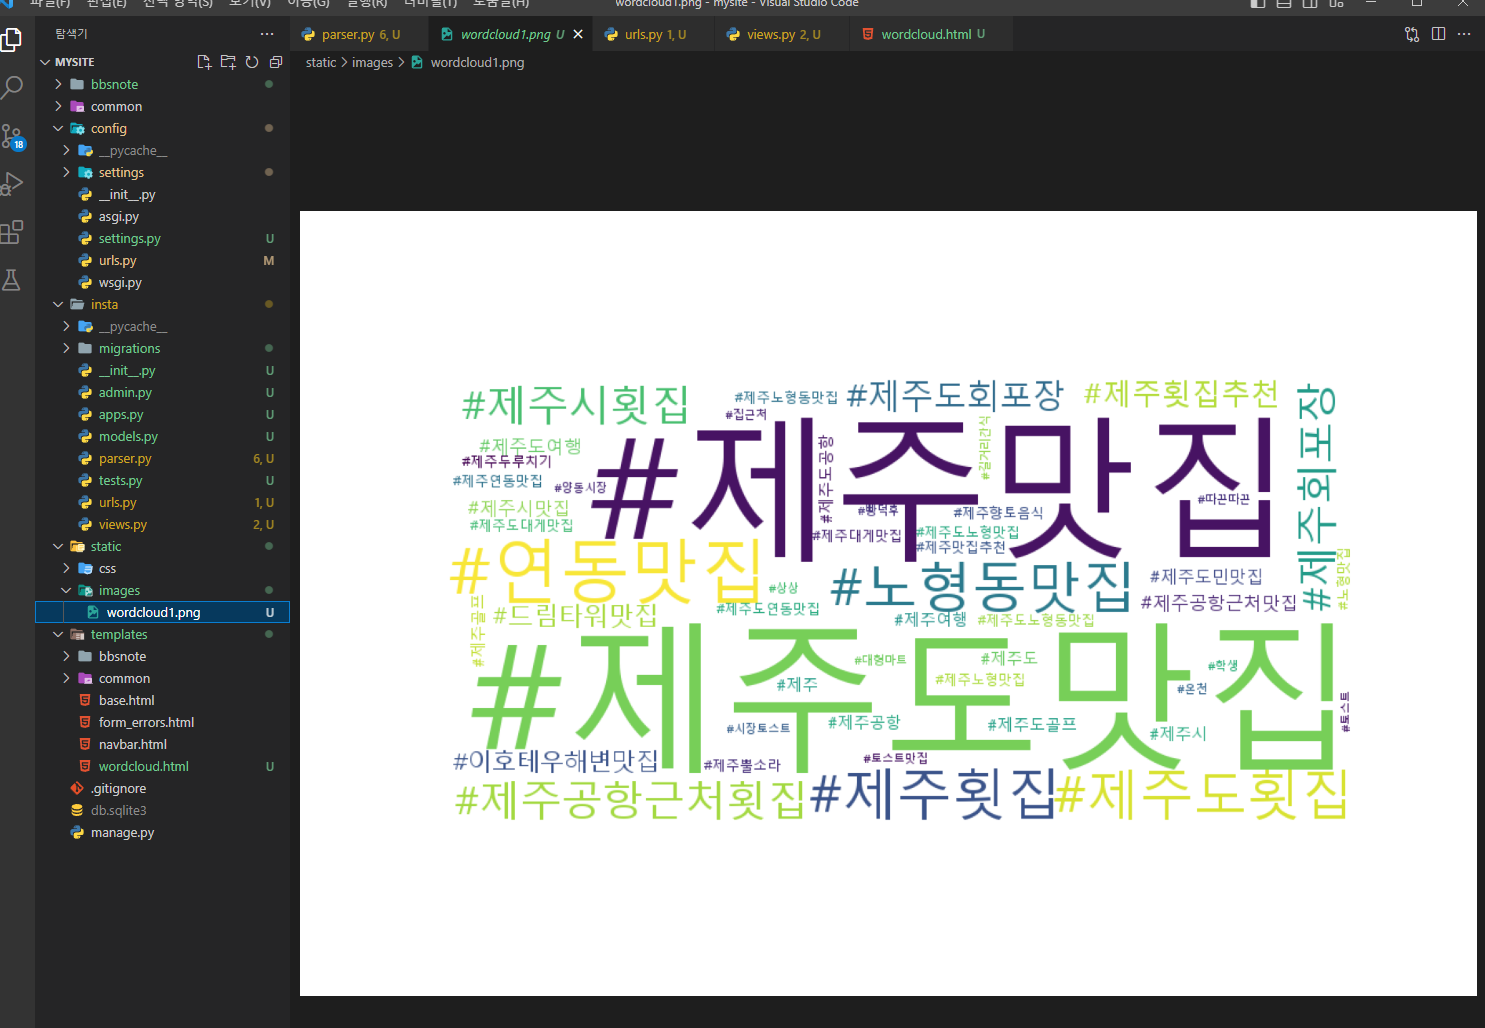

## 지도시각화

In [ ]:
# url 설정
# insta/url.py파일에서 지도 출력을 위한 URL 패턴 추가
urlpatterns = [
    path('', views.index, name = 'index'),
    # 워드클라우드를 실행시킬 URL패턴
    path('wordcloud/', views.wordcloud, name='wordcloud'),
    path('map/', views.map, name='map'),
]

In [ ]:
# views.py파일에 지도 시각화를 위한 함수를 만들어준다.
def map(request):
    # SELECT place FROM Insta.insta
    # exclude(place='') -> place에 있는 ''(빈 값)은 제외하여 필터링해준다.
    places = Insta.objects.exclude(plcae='').values('place')
    places_df = pd.DataFrame(places)
    makeMap(places_df)
    return render(request, 'map.html')

In [ ]:
# parser.py에 지도 출력을 위한 기능함수들을 정의해준다.
# 패키지 추가
import pandas as pd
import requests
import folium
from folium.plugins import MarkerCluster

# 지도출력을 위한 기능함수
def makeMap(places_df):
    places_counts = places_df.value_counts()
    df_location_counts = pd.DataFrame(places_counts)
    locations = list(df_location_counts.index)
    
    # 인스타그램 데이터의 위치정보 검색
    locations_inform = []
    for location in locations:
        try:
            data = find_places(location)
            locations_inform.append(data)
            # 과도하게 빠른 요청 때문에 차단 오류 발생 가능성 방지
            time.sleep(1)
        except:
            pass
    locations_inform_df = pd.DataFrame(locations_inform)
    locations_inform_df.columns = ['name_official', '경도', '위도', '인스타위치명']
    location_data = pd.merge(locations_inform_df, df_location_counts, how = 'inner', left_on = 'name_official', right_index = True)
    location_data = location_data.pivot_table(index = ['name_official', '경도', '위도'], values = 'count', aggfunc = 'sum')
    location_data = location_data.reset_index()
    print(location_data)
    
    Mt_Hanla = [33.362500, 126.533694]
    map_jeju = folium.Map(location=Mt_Hanla, zoom_start = 11)
    
    locations = []
    names = []
    for i in range(len(location_data)):
        # 행 하나씩
        data = location_data.iloc[i]
        locations.append((float(data['위도']), float(data['경도'])))
        names.append(data['name_official'])
        
    icon_create_function = """\
    function(cluster){
        return L.divIcon({
        html:'<b>' + cluster.getChildCount() + '</b>',
        className: 'marker-cluster marker-cluster-large',
        iconsize: new L.point(30, 30)
        });
    }"""
    marker_cluster = MarkerCluser(
        locations = locations, popups = names,
        name = 'Jeju',
        overlay = True,
        control = True,
        icon_create_function = icon_create_function
    )
    
    marker_cluster.add_to(map_jeju)
    folium.LayerControl().add_to(map_jeju)
    map_jeju.save(BASE_DIR/"templates/map.html")
    
# 카카오 키워드 검색 API로 위치 정보 검색 함수
def find_places(searching):
    # 접속 URL
    url = 'https://dapi.kakao.com/v2/local/search/keyword.json?query={}'.format(searching)
    headers = {
        "Authorization": "KakaoAK b3d8529dc0fc9d5c4c8e66df2f0f9184"
    }
    # API 요청 & 정보 받기
    places = requests.get(url, headers = headers).json()['documents']
    
    # 필요한 정보 입력
    # 최대 5개 정보가 저장되어 넘어오고, 그 중 첫번째 결과를 활용
    place = places[0]
    
    names = place['place_name']
    x = place['x']
    y = place['y']
    # 장소명, x좌표, y좌표, 검색어를 리스트형태로 저장
    data = [name, x, y, searching]
    
    return data

* 앞서서 target변수에 적은 값을 대입한 결과를 토대로 지도를 도출 한 것이므로, 아래와 같이 카카오API와 매칭되는 지명이 아니면 valueError가 발생할 수 있으므로, 보다 정확한 시각화를 위해서는 충분한 양의 데이터를 수집하는 것이 필요하다.

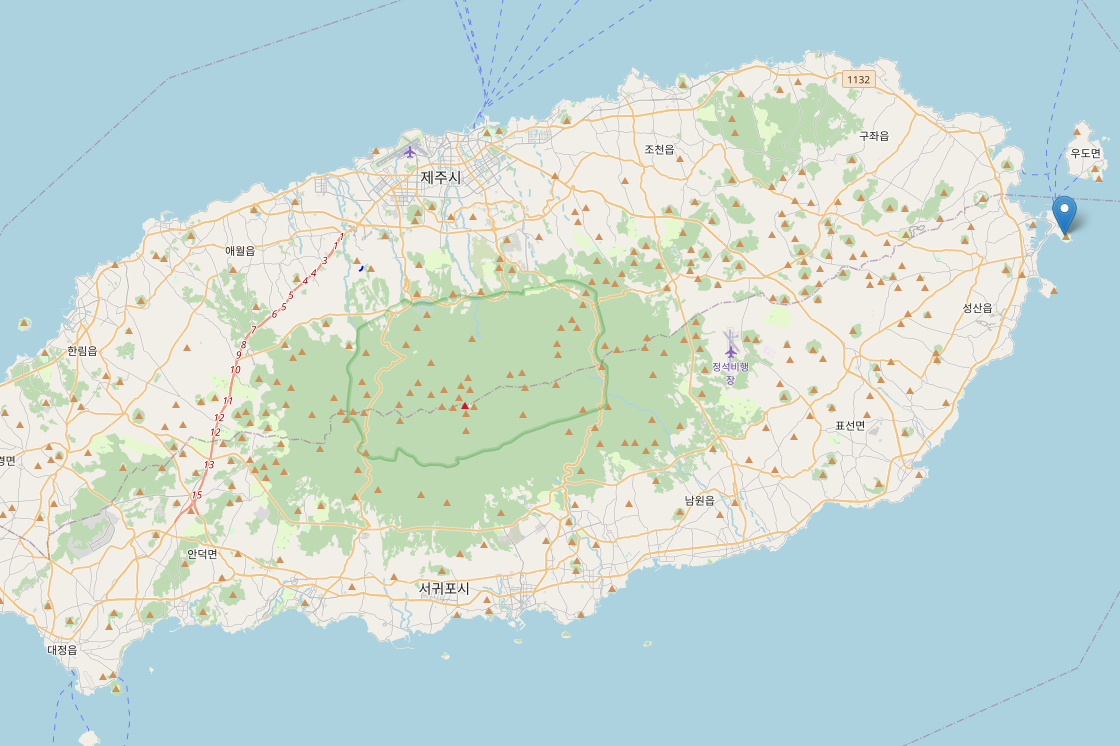

* 데이터를 좀 더 많이 수집하게 되면 아래와 같이 표시 구역이 늘어남을 알 수 있다.

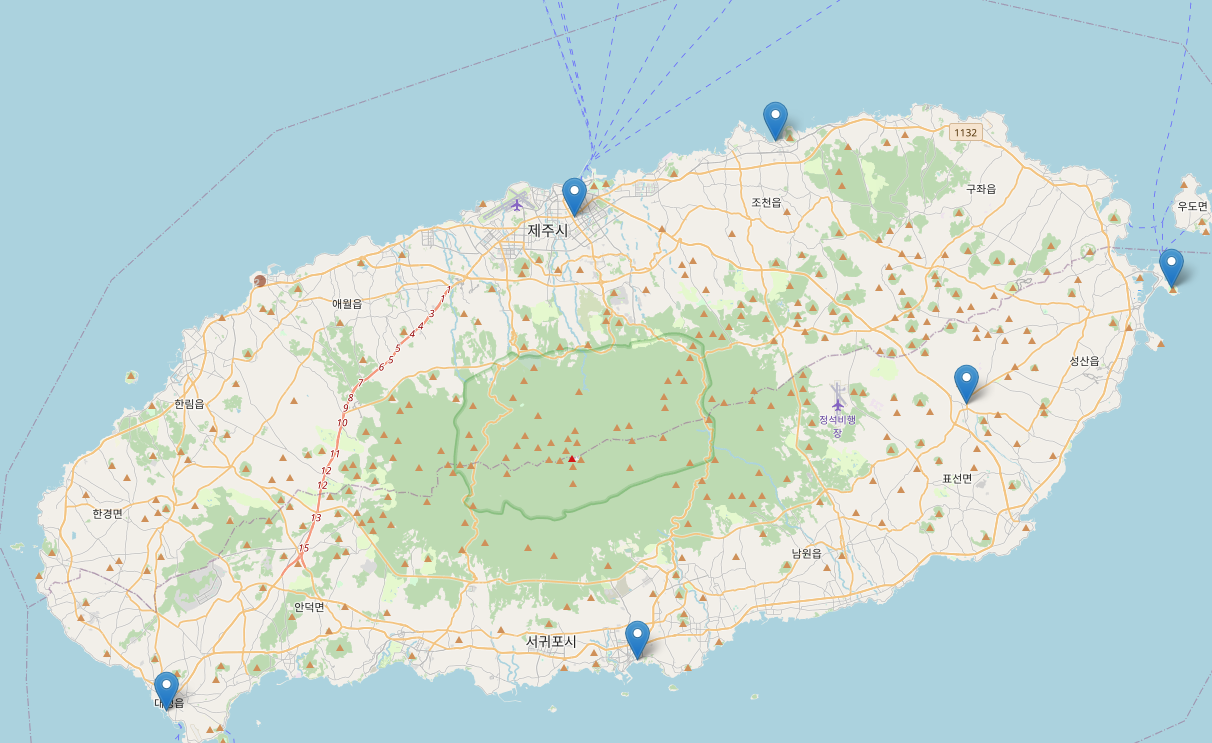